In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import random
from sklearn.model_selection import train_test_split
import tensorflow.keras.datasets.cifar10
import keras
from keras_preprocessing.image import ImageDataGenerator
from functools import partial
from confusion_matrix import make_confusion_matrix
from sklearn.metrics import confusion_matrix

# Bronnen:

- hands on machine learning with scikit-learn keras and tensorflow: Chapter 14 - Deep Computer Vision Using Convolutional Neural Networks
- MIT 6.S191 (2020): Convolutional Neural Networks (https://www.youtube.com/watch?v=iaSUYvmCekI)
- https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
- Dropout: A Simple Way to Prevent Neural Networks from Overfitting  (https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)



# Data Preparation

In [2]:
# zonder dit krijg ik een error bij het downloaden van de dataset
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
data = keras.datasets.cifar10.load_data()

In [4]:
label_dict = {0:'airplane', 1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}

In [5]:
(X_train, y_train), (X_test, y_test) = data

In [6]:
# one-hot encode the targets
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [7]:
X_train.shape

(50000, 32, 32, 3)

# Data Augmentation
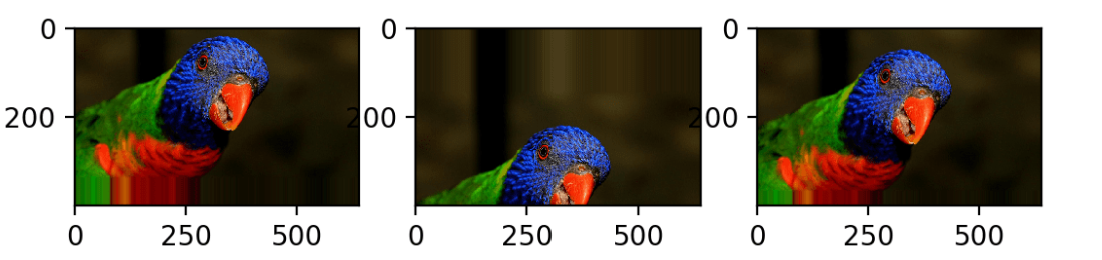
Positief effect op accuracy:

    - horizontal flip
    - brightness

Negatief of geen effect op accuracy:

    - height/width shift
    - rotation
    - zoom


In [8]:
datagen = ImageDataGenerator(horizontal_flip=True, brightness_range=[0.5,1.5])
batch_size = 64
it_train = datagen.flow(X_train, y_train, batch_size=batch_size)
steps = len(X_train)/batch_size


# Het Model

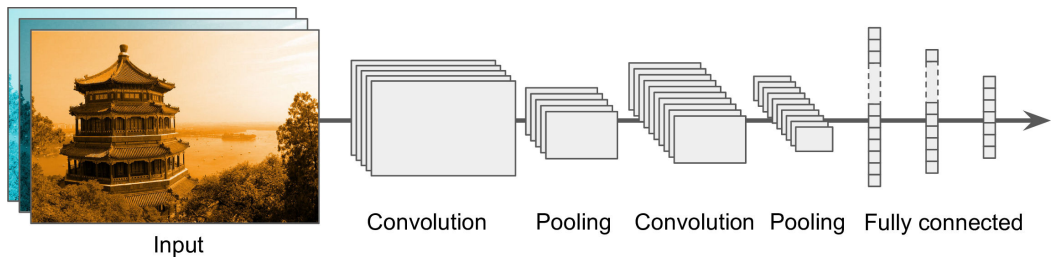

Ik zal zo veel mogelijk proberen uit te leggen waarom ik specifieke variabelen en inputs voor layers kies. Waar ik dit niet doe kan worden aangenomen dat ik default of vaak voorkomende waardes gebruik of de waardes gebruik die het best werken na zelf te hebben geëxperimenteerd. Ik heb alle voorgestelde regularisatiemethodes op canvas uitgeprobeerd, sommige hebben wat problemen met samenwerken (zoals L2 regularization en batch normalization). Hier onder is mijn best werkende model te vinden:

### - Rescaling Layers:
In deze layer wordt de input data genormaliseerd, de layer deelt alle waardes door de grootste waarde: 255. Dit zorgt er voor dat ons network sneller kan convergeren.


### - Convolutional Layers:
Convolutional layers worden gebruikt als 'feature extractors'. In een convolutional layer slide een filter (een matrix van x bij y getallen die een patroon representeerd) over onze image bitmap met als doel een map te maken van waar het filterpatroon overeenkomt met een deel van onze image. Dit wordt gedaan door de getallen in het filter te vermenigvuldigen met de getallen van het deel van de de bitmap waar het filter op wordt toegepast en daar de som van te nemen, eventueel een bias er aan toe te voegen, en het in een activatie functie te stoppen.We gebruiken hier de non-lineaire activatiefunctie ReLu voor omdat onze data ook non-lineair is. Dit resultaat is dan één getal in de nieuwe feature map. Hoe vaak dit wordt gedaan is afhankelijk van de grootte van het filter, de grootte van de bitmap, en de strides variabele (de horizontale en verticale stapgrootte). De filters variabele geeft aan hoeveel van deze feature maps, met verschillende filters, worden gemaakt.

Je kan zien dat na elke convolutional + pooling cycle het aantal filters verdubbeld wordt. Dit wordt zo gedaan omdat des te dieper je het netwerk in gaat des te complexer de patronen, en vooral de combinaties van patronen worden. Een van de eerdere convolutional layers kijkt dus bijvoorbeeld naar relatief simpele patronen zoals randen, maar de latere convolutional layers kunnen deze randen samenvoegen om meer complexere vormen te herkennen zoals een vleugel van een vliegtuig. Dit vergt natuurlijk redelijk veel computationele kracht en is dan ook een van de redenen om de volgende soort layers te gebruiken:

### - Pooling Layers:
Waar in onze convolutional layer het filter willekeurig geïnitialiseerd werd werkt het bij pooling layers net even iets anders. Bij max pooling (de methode die ik gebruik) wordt er ook een filter toegepast op de bitmap maar dit filter neemt alleen het grootste getal op het toegepaste deel over naar de feature map. Het maakt in principe dus een soort samenvatting van de bitmap. Dit is een vorm van downsampling. Pooling layers leiden tot een enorme performance gain voor ons netwerk. Dit verminderen van je features kan ook helpen tegen overfitting.

### - Dense Layers:
De dense layer(s) zijn verantwoordelijk voor het classificeren van de extracted features uit de convolutional layers.

### - Dropout Layers:
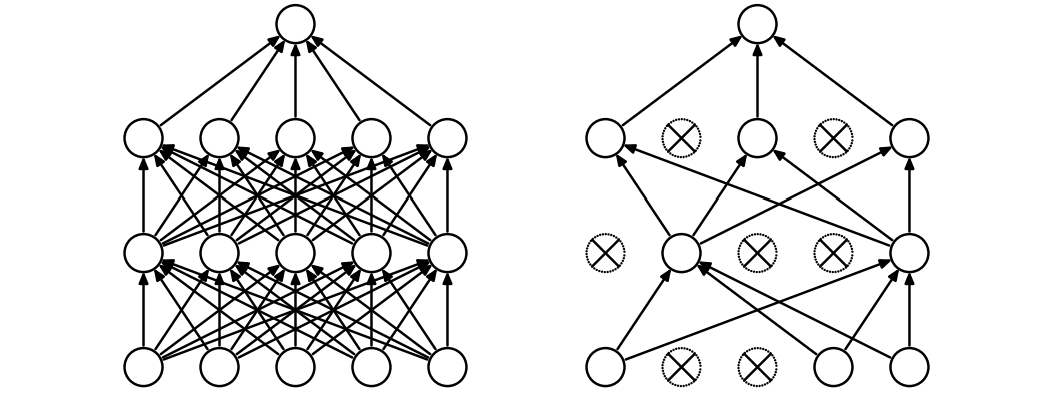
Dropout zorgt er voor dat er een deel van de neurons en connecties van die neurons willekeurig worden uitgezet. Dit helpt tegen overfitting omdat neuronen nu niet te veel kunnen afhangen van andere specifieke neuronen (want er is een kans dat deze gedropped worden, en het netwerk moet dan natuurlijk wel goed blijven werken).

### - Output Layer:
We hebben een output layer van 10 neurons groot (voor alle 10 de mogelijke image labels). We gebruiken de Softmax activatie functie zodat we een kansverdeling als output terug krijgen.

### - Optimizers:
Ik heb Adam en SGD(met verschillende lr en performance waardes) uitgeprobeerd. Adam scoort zo'n 2% hoger op accuracy dan het best werkende SGD model.

### - Callbacks:
Ik gebruik een early stopping callback die na x keer geen verbetering in de test/validation loss het netwerk stopt. Voor SGD heb ik exponential decay en step decay lr-schedulers gebruikt maar deze verbeterde het netwerk niet.

In [12]:
from keras.regularizers import l2
# deze parameters worden voor alle convolutional layers gebruikt
DefaultConv2D = partial(keras.layers.Conv2D,
 kernel_size=3, activation='relu', padding="same", kernel_initializer = 'he_uniform')


model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(32, 32, 3)),
    
    DefaultConv2D(filters = 32),
    tf.keras.layers.BatchNormalization(),
    DefaultConv2D(filters = 32),
    tf.keras.layers.BatchNormalization(),
    DefaultConv2D(filters = 32),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.1),
    
    DefaultConv2D(filters = 64),
    tf.keras.layers.BatchNormalization(),
    DefaultConv2D(filters = 64),
    tf.keras.layers.BatchNormalization(),
    DefaultConv2D(filters = 64),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.2),
    
    DefaultConv2D(filters = 128),
    tf.keras.layers.BatchNormalization(),
    DefaultConv2D(filters = 128),
    tf.keras.layers.BatchNormalization(),
    DefaultConv2D(filters = 128),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.3),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation = 'relu', kernel_initializer = 'he_uniform'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(10,activation = 'softmax')
])

model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy']
              
             )


early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                              patience=5)

history = model.fit(it_train ,epochs = 10000,validation_data = (X_test,y_test), callbacks = [early_stop], batch_size = 64)

Epoch 1/10000
782/782 [==============================] - 13s 16ms/step - loss: 2.1982 - accuracy: 0.3634 - val_loss: 1.2904 - val_accuracy: 0.5465
Epoch 2/10000
782/782 [==============================] - 12s 15ms/step - loss: 1.2892 - accuracy: 0.5472 - val_loss: 1.0730 - val_accuracy: 0.6205
Epoch 3/10000
782/782 [==============================] - 13s 17ms/step - loss: 1.0586 - accuracy: 0.6291 - val_loss: 0.8883 - val_accuracy: 0.6895
Epoch 4/10000
782/782 [==============================] - 16s 20ms/step - loss: 0.9272 - accuracy: 0.6771 - val_loss: 0.8393 - val_accuracy: 0.7147
Epoch 5/10000
782/782 [==============================] - 12s 16ms/step - loss: 0.8258 - accuracy: 0.7150 - val_loss: 0.6823 - val_accuracy: 0.7640
Epoch 6/10000
782/782 [==============================] - 12s 16ms/step - loss: 0.7462 - accuracy: 0.7441 - val_loss: 0.6724 - val_accuracy: 0.7708
Epoch 7/10000
782/782 [==============================] - 12s 16ms/step - loss: 0.7044 - accuracy: 0.7602 - val_loss: 0

In [13]:
def random_classification():
    index = random.randint(0,len(X_test)-1)
    prediction = model.predict(np.expand_dims(X_test[index], axis = 0))
    label = label_dict[np.argmax(y_test[index])]
    predicted_label = label_dict[np.argmax(prediction)]
    plt.imshow(X_test[index])
    plt.title(f"Real: {label} \nPrediction: {predicted_label}\n", color = 'green' if label == predicted_label else 'red')
    plt.show()


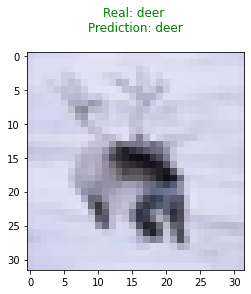

In [14]:
random_classification()

In [15]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_27 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_30 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_28 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_31 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_29 (Conv2D)          (None, 32, 32, 32)       

In [16]:
def plot_loss(history):
    
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()
 

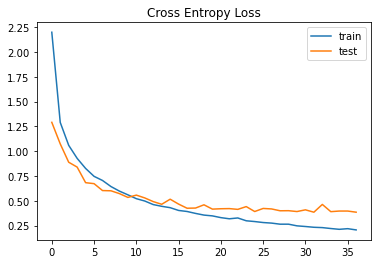

In [17]:
plot_loss(history)

In [18]:
test_preds = model.predict(X_test)
test_preds_num = [label_dict[tf.argmax(x).numpy()] for x in test_preds]

In [19]:
cm = confusion_matrix([label_dict[np.argmax(x)] for x in y_test],test_preds_num)

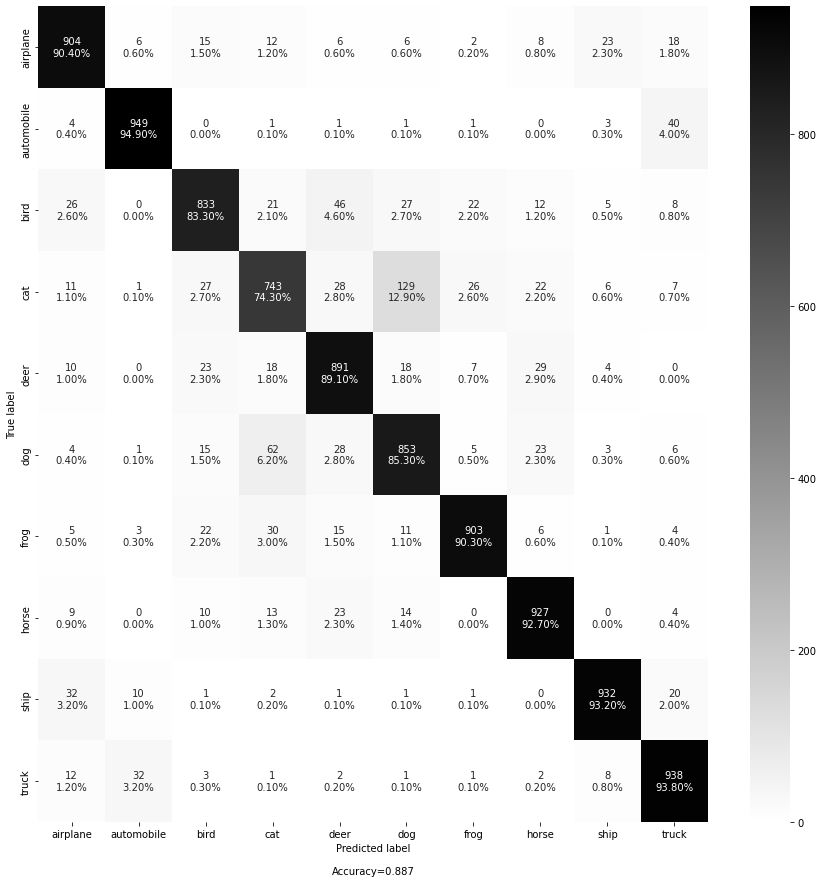

In [20]:
make_confusion_matrix(cm, 
                      cmap= 'binary',
                      figsize = (15,15),
                      categories = list(label_dict.values()))

plt.show()

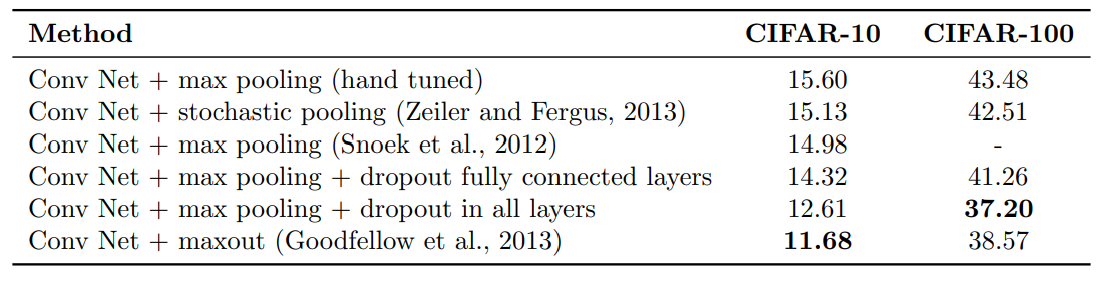